# Effect of Job Training on Future Earnings

**Course:** Foundations of Data Science  

**Group Members:** Nibish Tamrakar, Karthik Subramanium, Zubair Ali L

---

## 1. Introduction

### 1.1. The Question / Estimand

*What is the causal effect of participating in a job training program on future earnings, after adjusting for prior earnings?*

---

### 1.2. Data Description

- **Data Source:**  
  The analysis uses data from the National Supported Work (NSW) job training experiment compiled by LaLonde (1986), available via the NBER repository:  
  <https://users.nber.org/~rdehejia/data/.nswdata2.html>

- **Rows:**  
  Each row corresponds to one individual participant in the study *(722 individuals total)*.

- **Columns:**  
  The dataset includes indicators for program participation and earnings outcomes, along with background measures. Key variables used in our causal analysis are:
  - **treat:** Binary indicator of participation in the job training program  
    *(1 = treated, 0 = control)*
  - **re75:** Earnings in 1975 (pre-treatment), representing baseline economic status
  - **re78:** Earnings in 1978 (post-treatment), representing the outcome of interest

- **Relevance to the Causal Question:**  
  This dataset is well suited for estimating the causal effect of job training on future earnings because it originates from a randomized training program, providing credible treatment assignment. Crucially, it includes prior earnings (**re75**) measured before treatment, which plausibly influences both participation and later earnings. Adjusting for this confounder allows us to isolate the causal impact of training on post-program earnings (**re78**). Additionally, the clear temporal ordering — *baseline earnings → training participation → future earnings* — aligns directly with our estimand.


## 2. Causal Model

<img src="job_training_dag.png" style="display:block; margin:auto;" width="450">

*The Directed Acyclic Graph (DAG) consists of three nodes and three directed edges:*

- **re75 → treat**
- **re75 → re78**
- **treat → re78**

*This DAG is connected and acyclic, representing our assumptions about how prior earnings, job training participation, and future earnings are causally related.*

### 2.1. Variables

*(Clearly label and describe your three variables (Treatment, Outcome, Confound). Do not use T, Y, Z. Use symbols that reflect the names of the variables from your dataset.)*

- **Treatment (treat):**  
  Binary indicator of participation in the job training program  
  *(1 = participated in training, 0 = did not participate)*

- **Outcome (re78):**  
  Individual earnings in 1978, measured after the job training period

- **Confound (re75):**  
  Individual earnings in 1975, measured before treatment and used as a proxy for baseline economic status, skill level, and employability

### 2.2. Assumed Causal Relationships

*The causal model assumes that prior earnings (**re75**) influence both job training participation (**treat**) and future earnings (**re78**). Individuals with lower or unstable earnings before the program may be more likely to enroll in job training, creating a causal path from **re75 → treat**. At the same time, prior earnings strongly predict later earnings due to persistent differences in skills, work experience, and labor market opportunities, forming the path **re75 → re78**.*

*The primary causal effect of interest is the direct impact of job training participation on future earnings, represented by **treat → re78**. Because **re75** affects both treatment assignment and the outcome, it acts as a confounder. Adjusting for **re75** blocks the backdoor path between **treat** and **re78**, allowing us to identify the causal effect of job training on future earnings under the assumptions encoded in the DAG.*


## 3. Statistical Model

We model **post-program earnings** in 1978 (`re78`) on the log scale to account for non-negativity and right-skewness. Let $Y_i = \text{re78}_i$ denote earnings in 1978 for individual $i$, and let $\text{treat}_i$ and $\text{re75}_i$ denote treatment status and prior earnings in 1975, respectively.

We assume the following statistical model:

$$
\log(Y_i + 1) \sim \text{Normal}(\mu_i, \sigma)
$$

$$
\mu_i = \alpha + \tau \cdot \text{treat}_i + \beta \cdot \log(1 + \text{re75}_i)
$$

where:
- $\alpha$ is the intercept,
- $\tau$ captures the causal effect of job training participation on (log) future earnings, after adjusting for prior earnings,
- $\beta$ measures the association between prior earnings and future earnings on the log scale.

We place the following priors on the parameters:

$$
\alpha \sim \text{Normal}(0, 5)
$$

$$
\tau \sim \text{Normal}(0, 5)
$$

$$
\beta \sim \text{Normal}(0, 5)
$$

$$
\sigma \sim \text{Half-Cauchy}(0, 2)
$$

---

### 3.1. Justification of Priors

The priors are chosen to be **weakly informative**, reflecting plausible ranges for effects while allowing the data to play the dominant role:

- The parameters $\alpha$, $\tau$, and $\beta$ are given $\text{Normal}(0, 5)$ priors.  
  On the log-earnings scale, a change of 5 units corresponds to a very large multiplicative change in earnings (e.g., $\exp(5) \approx 148$), so these priors are intentionally wide. This ensures we are not tightly constraining the regression coefficients while still discouraging extremely large, implausible values.

- The residual standard deviation $\sigma$ is given a $\text{Half-Cauchy}(0, 2)$ prior, a common weakly informative prior for scale parameters. It favors smaller values of $\sigma$ while still allowing for moderately large residual variation if supported by the data.

Overall, these priors encode the belief that:
1. Effects are likely to be centered near zero on the log scale (no strong prior belief about large positive or negative effects), and  
2. The model allows enough flexibility to fit realistic earnings patterns without over-regularizing.

---

### 3.2. Justification of Outcome Distribution

Raw earnings (`re78`) are:
- **Non-negative**,  
- **Right-skewed**, with a small number of individuals earning much more than the median, and  
- Sometimes equal to zero.

To address these characteristics, we model $\log(Y_i + 1)$ rather than $Y_i$ directly:

- The log transformation reduces right skew and makes the distribution of transformed earnings closer to symmetric and approximately Normal.
- Adding 1 inside the log, $\log(Y_i + 1)$, allows us to handle individuals with zero earnings without discarding them or requiring a separate model.
- On the transformed scale, it is reasonable to assume approximately constant variance and a Normal error distribution, which justifies the Normal likelihood:
  $$
  \log(Y_i + 1) \sim \text{Normal}(\mu_i, \sigma).
  $$

Thus, the Normal distribution is used not for raw earnings, but for their log-transformed values, which better match the assumptions of the statistical model.


---

### 3.3. Handling the Confound

Our causal DAG indicates that prior earnings in 1975 (`re75`) act as a **confounder**, affecting both:

- The probability of participating in the job training program (`treat`), and  
- Future earnings in 1978 (`re78`).

In the statistical model, we handle this confounding by **conditioning on `re75`** through its log-transformed version:

$$
\mu_i = \alpha + \tau \cdot \text{treat}_i + \beta \cdot \log(1 + \text{re75}_i).
$$

Including $\log(1 + \text{re75}_i)$ in the regression:

- Blocks the backdoor path $\text{treat} \leftarrow \text{re75} \rightarrow \text{re78}$,  
- Ensures that the estimated coefficient $\tau$ reflects the effect of job training on future earnings **after adjusting for differences in baseline earnings**, and  
- Aligns directly with the causal model specified in the DAG.

Under the assumptions encoded in the DAG (no unmeasured confounding beyond `re75`, correct model specification, and appropriate temporal ordering), the posterior for $\tau$ can be interpreted as a **causal effect** of job training on log-transformed future earnings, conditional on prior earnings.



## 4. Model Validation on Simulated Data

*(Before analyzing the real data, you must validate your statistical model on simulated data where you pre-define the parameter values, construct a posterior approximation of your model using the simulated data, and evaluate how well your model estimates the pre-defined parameter values.)*

*(**Hint:** Use `arviz.plot_posterior()` with the `ref_val` parameter set to your fixed simulation parameter values to check how well your model estimates them. )*

## 4. Model Validation on Simulated Data

Before analyzing the real NSW job training data, we first validate our statistical model using simulated data. The goal is to check whether the model can recover known parameter values when the data are generated directly from the assumed data-generating process.

We follow these steps:

1. **Define fixed parameter values** (e.g., $\alpha_{\text{sim}}$, $\tau_{\text{sim}}$, $\beta_{\text{sim}}$, $\sigma_{\text{sim}}$).  
2. **Simulate data** from our causal/statistical model using these fixed values.  
3. **Fit the same Bayesian model (using PyMC)** to the simulated data.  
4. **Check how well the posterior recovers the true parameter values** using `arviz.plot_posterior()` with the `ref_val` argument set to the fixed simulation values.

Our simulation uses the same model structure as in Section 3:

$$
\log(Y_i + 1) \sim \text{Normal}(\mu_i, \sigma)
$$

$$
\mu_i = \alpha + \tau \cdot \text{treat}_i + \beta \cdot \log(1 + \text{re75}_i).
$$


In [1]:
# 1. Define fixed parameter values (e.g., alpha_sim = 0.3, beta_sim = 0.5, etc)

# 2. Simulate data based on your causal/statistical model using these fixed values

# 3. Run your computational model (using PyMC) on this simulated data

# 4. Check how well your model estimates the parameter values. Do the posterior estimates from the model capture the true values you defined?


In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# For reproducibility
rng = np.random.default_rng(123)

# ==============================
# 1. Define fixed parameter values
# ==============================
alpha_sim = 0.3   # intercept
tau_sim   = 0.5   # effect of treatment on log-earnings
beta_sim  = 0.7   # effect of log(1 + re75) on log-earnings
sigma_sim = 0.6   # residual standard deviation

N = 800  # number of simulated individuals

# ==============================
# 2. Simulate data from the model
# ==============================

# Simulate prior earnings re75 (positive, right-skewed)
re75_sim = rng.lognormal(mean=9, sigma=0.6, size=N)

# Simulate treatment assignment with some dependence on re75
# (Lower re75 -> slightly higher probability of treatment)
logit_p = 0.5 - 0.00005 * (re75_sim - np.mean(re75_sim))
p_treat = 1 / (1 + np.exp(-logit_p))
treat_sim = rng.binomial(1, p_treat, size=N)

# Mean on the log scale
mu_sim = alpha_sim + tau_sim * treat_sim + beta_sim * np.log1p(re75_sim)

# Simulate log-earnings
log_y_sim = rng.normal(mu_sim, sigma_sim, size=N)

# Transform back to earnings scale
re78_sim = np.exp(log_y_sim) - 1

sim_data = pd.DataFrame({
    "re75": re75_sim,
    "treat": treat_sim,
    "re78": re78_sim
})

sim_data.head()

,re75,treat,re78
0,4476.188535,0,734.860491
1,6498.508767,1,1340.558069
2,17549.051060,1,3658.099752
3,9103.230700,1,1044.015626
4,14074.761948,1,1100.449161


In [3]:
# ==============================
# 3. Run the PyMC model on simulated data
# ==============================

import numpy as np
import pymc as pm
import arviz as az

with pm.Model() as sim_model:
    # --- Data (note: log transform done OUTSIDE the graph) ---
    re75 = pm.MutableData("re75", sim_data["re75"].values)
    treat = pm.MutableData("treat", sim_data["treat"].values)
    y_log = pm.MutableData("y_log", np.log1p(sim_data["re78"].values))  # log(1 + y)

    # --- Priors ---
    alpha = pm.Normal("alpha", 0, 5)
    tau   = pm.Normal("tau", 0, 5)
    beta  = pm.Normal("beta", 0, 5)
    sigma = pm.HalfCauchy("sigma", 2)

    # --- Mean structure on log scale ---
    mu = alpha + tau * treat + beta * pm.math.log(1 + re75)

    # --- Likelihood: log(Y_i + 1) ~ Normal(mu, sigma) ---
    log_y = pm.Normal("log_y", mu=mu, sigma=sigma, observed=y_log)

    # --- Sample from posterior ---
    idata_sim = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=123
    )



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha, tau, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 192 seconds.


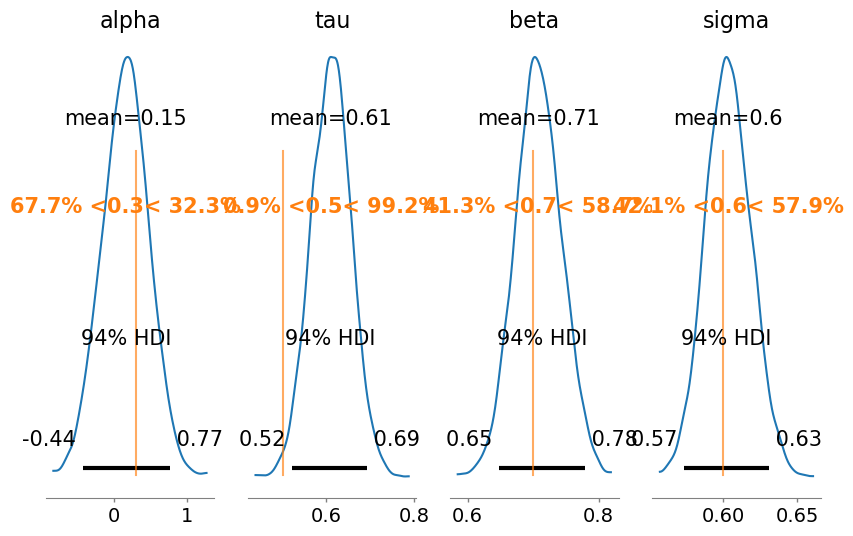

In [4]:
# ==============================
# 4. Check how well the model recovers the true values
# ==============================

true_vals = {
    "alpha": alpha_sim,
    "tau": tau_sim,
    "beta": beta_sim,
    "sigma": sigma_sim
}

az.plot_posterior(
    idata_sim,
    var_names=["alpha", "tau", "beta", "sigma"],
    ref_val=[true_vals["alpha"],
             true_vals["tau"],
             true_vals["beta"],
             true_vals["sigma"]],
    figsize=(10, 6)
);


*(Provide a brief discussion of the simulation results, confirming that your model can successfully recover the fixed parameters.)*

## 5. Data Preparation (Real Data)

*(Load the real dataset. Perform any necessary cleaning, scaling, or transformations. )*

In [5]:
# Load data 

# Perform any cleaning/scaling/transformations 

In [6]:
import pandas as pd

# Define input and output file paths
dta_file = 'DATA/nsw.dta'
csv_file = 'DATA/nsw.csv'

try:
    # Read the .dta file
    df = pd.read_stata(dta_file)

    # Convert to CSV
    df.to_csv(csv_file, index=False)

    print(f"Successfully converted '{dta_file}' to '{csv_file}'")

except FileNotFoundError:
    print(f"Error: The file '{dta_file}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully converted 'DATA/nsw.dta' to 'DATA/nsw.csv'


## 6. Posterior Model (Analysis on Real Data)

*(This section contains the code for your computational model and the analysis of its output.)*

### 6.1. Computational Model Definition and Sampling

*(Provide the code for your PyMC model.  Ensure the code is well-organized and understandable. )*

In [ ]:
# Define your statistical model in code (e.g., with pm.Model() as model: ...) and sample from the model


### 6.2. Model Diagnostics

*(Use built-in diagnostics to assess the quality of the posterior samples (e.g., trace plots, r-hat, effective sample size). )*

In [ ]:
# Show posterior summary

# Plot trace plots

# Check R-hat and ESS

*(Briefly discuss the diagnostics. Did the model converge? Are the samples of good quality?)*

## 7. Posterior Predictive Checks

*(Visually compare your model's posterior predictions to the observed data. )*

*(The plot(s) in this section should include: )*
* *The observed data*
* *The posterior mean*
* *The uncertainty of the posterior mean (e.g., 89% HDI)*
* *The uncertainty of posterior predictions (e.g., 89% HDI)*

In [ ]:
# Generate posterior predictive samples

# Create the posterior predictive check plot(s)


*(Discuss the results of the check(s). How well does your posterior approximation fit the observed data? Are there any notable discrepancies? )*

## 8. Discussion and Conclusion

### 8.1. Answering the Question

*(Discuss what was learned from the model. )*
* *What is the answer to the question you posed in the introduction?*
* *What is your estimate for the causal effect? Provide a plot showing the estimate of the distribution of the causal effect.*
* *Ensure your conclusions are supported by the evidence from your model results. *

### 8.2. Addressing the Confound

*(Explicitly address the confounding variable in your discussion. )*
* *What was the effect of the confound?*

## 9. Future Work

*(Use your current model results to guide future plans for expanding the analysis. )*

* *What are the limitations of your model?*
* *What other variables would you want to include to expand your inquiry?*
* *What other questions might you explore given what you have learned from your analysis?*

## 10. Group Member Contributions

*(List each section of the proposal and final write-up and state who worked on it.)*

* **Proposal:** Nibish Tamrakar, Karthik Subramanium,  Zubair Ali L
* **Introduction:** Nibish Tamrakar
* **Causal Model:** Nibish Tamrakar
* **Statistical Model:** Nibish Tamrakar
* **Model Validation on Simulated Data:** Member Name 1, Member Name 2
* **Data Preparation:** Member Name 3
* **Posterior Model (Analysis on Real Data):** Member Name 1
* **Posterior Predictive Checks:** Member Name 2
* **Discussion and Conclusion:** Member Name 3
* **Future Work:** Member Name 1, Member Name 2, Member Name 3
